Importando drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Librerias de apoyo

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
from numpy import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

Dataframe de datos

In [ ]:
# Revisamos el directorio de datos

!ls -lth "/content/drive/My Drive/Colab Notebooks/SDC_13/datos"

total 1.3M
drwx------ 2 root root 4.0K Jan 11 23:35 IMG
-rw------- 1 root root 1.3M Jan 11 21:36 driving_log.csv


In [ ]:
# Definimos una variable con la dirección del directorio de datos y uno con el nombre de las columnas para el dataframe que estaremos utilizando
datadir = "/content/drive/My Drive/Colab Notebooks/SDC_13/datos"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

In [ ]:
# Definimos nuestro DataFrame

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_335.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_335.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_335.jpg,0.0,0.0,0,0.000078
1,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_449.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_449.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_449.jpg,0.0,0.0,0,0.000079
2,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_584.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_584.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_584.jpg,0.0,0.0,0,0.000080
3,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_687.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_687.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_687.jpg,0.0,0.0,0,0.000078
4,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_788.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_788.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_788.jpg,0.0,0.0,0,0.000083


In [ ]:
# Eliminamos toda la parte de la dirección local de las imagenes
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_01_11_15_26_24_335.jpg,left_2021_01_11_15_26_24_335.jpg,right_2021_01_11_15_26_24_335.jpg,0.0,0.0,0,0.000078
1,center_2021_01_11_15_26_24_449.jpg,left_2021_01_11_15_26_24_449.jpg,right_2021_01_11_15_26_24_449.jpg,0.0,0.0,0,0.000079
2,center_2021_01_11_15_26_24_584.jpg,left_2021_01_11_15_26_24_584.jpg,right_2021_01_11_15_26_24_584.jpg,0.0,0.0,0,0.000080
3,center_2021_01_11_15_26_24_687.jpg,left_2021_01_11_15_26_24_687.jpg,right_2021_01_11_15_26_24_687.jpg,0.0,0.0,0,0.000078
4,center_2021_01_11_15_26_24_788.jpg,left_2021_01_11_15_26_24_788.jpg,right_2021_01_11_15_26_24_788.jpg,0.0,0.0,0,0.000083


Exploración y selección de los datos

---



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd78cbd0b8>,
      dtype=object)

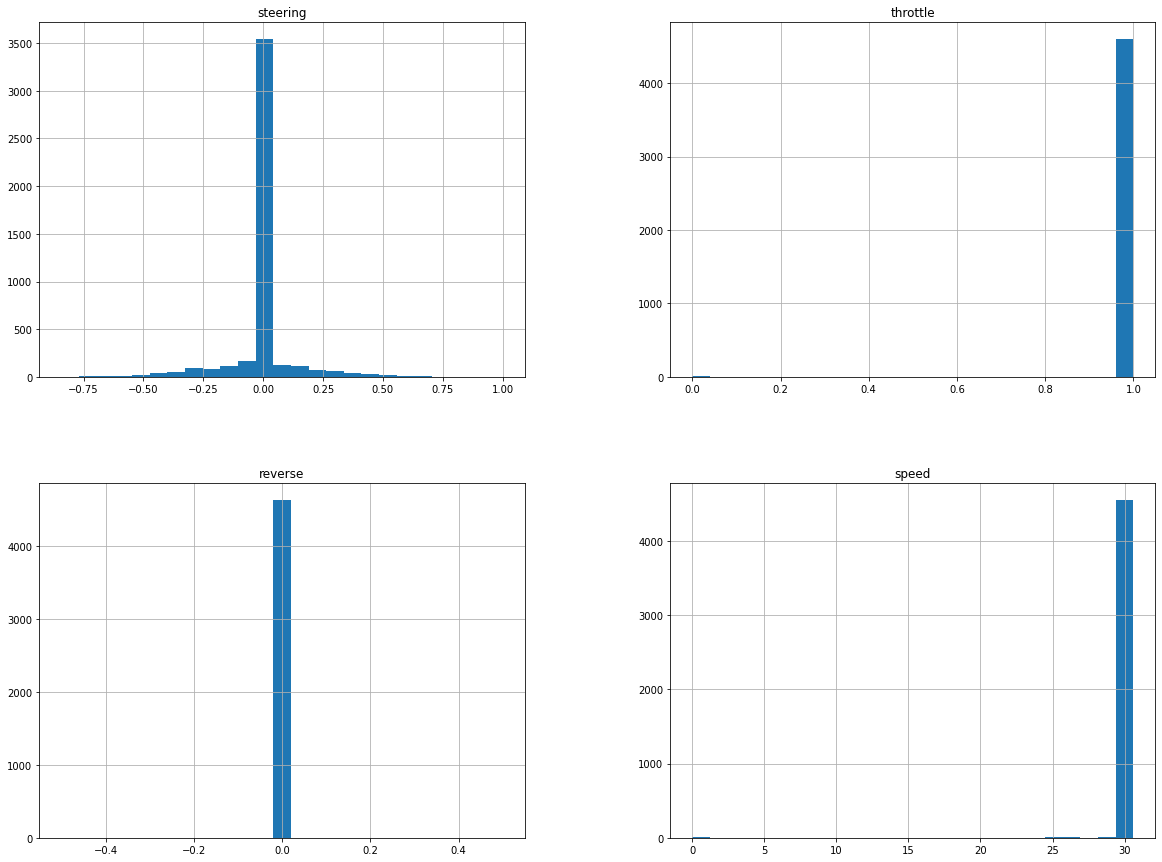

In [ ]:
# Exploración de los datos numéricos
data.hist(bins=25, figsize=(20,15))

Remover el exceso de datos con ángulo cero

In [ ]:
#Analizamos los datos de steering a través de su histograma

num_bins = 25
hist, bin_edges = np.histogram(data['steering'], num_bins)
center = (bin_edges [:-1]+ bin_edges [1:]) * 0.5

In [ ]:
print(center)

[-0.80540823 -0.7317181  -0.65802797 -0.58433784 -0.51064771 -0.43695757
 -0.36326744 -0.28957731 -0.21588718 -0.14219705 -0.06850691  0.00518322
  0.07887335  0.15256348  0.22625361  0.29994375  0.37363388  0.44732401
  0.52101414  0.59470427  0.66839441  0.74208454  0.81577467  0.8894648
  0.96315493]


In [ ]:
print(hist)

[   3    5    5    9   23   41   56   90   81  116  169 3539  123  113
   70   60   45   32   15   13    6    3    3    2    4]


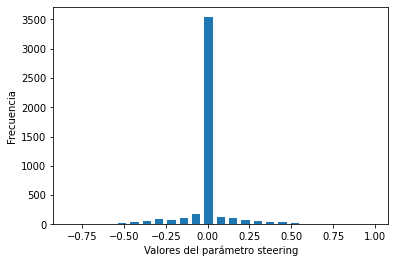

In [ ]:
#Graficamos cada valor con su frecuencia
plt.bar(center, hist, width=0.05)
plt.xlabel("Valores del parámetro steering")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
data['steering'][0:9]

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5   -0.123402
6   -0.255300
7    0.000000
8    0.000000
Name: steering, dtype: float64

In [ ]:
#Aquí se define el numero máximo de eventos y se eliminan aleatoriamente los restantes
maxFrec = 2500
remove_indexList = []
for i in range(len(data['steering'])):
  if data['steering'][i] == 0.0:
    remove_indexList.append(i)

remove_indexList = shuffle(remove_indexList)
remove_indexList = remove_indexList[maxFrec:]
print('Imágenes eliminadas:', len(remove_indexList))
data.drop(data.index[remove_indexList], inplace=True)
print('Imágenes restantes:', len(data))

Imágenes eliminadas: 978
Imágenes restantes: 3648


In [ ]:
data['steering'][0:10]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
5    -0.123402
6    -0.255300
7     0.000000
8     0.000000
9    -0.166296
10   -0.502236
Name: steering, dtype: float64

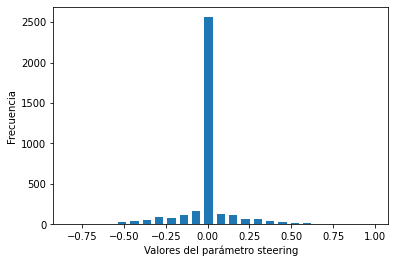

In [ ]:
#Graficamos cada valor con su frecuencia

hist, bin_edges = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.xlabel("Valores del parámetro steering")
plt.ylabel("Frecuencia")
plt.show()

Preparación de muestra de datos

In [ ]:
#Mostramos el dataFrame que se tiene hasta ahora

data.head(10)

,center,left,right,steering,throttle,reverse,speed
0,center_2021_01_11_15_26_24_335.jpg,left_2021_01_11_15_26_24_335.jpg,right_2021_01_11_15_26_24_335.jpg,0.000000,0.000000,0,0.000078
1,center_2021_01_11_15_26_24_449.jpg,left_2021_01_11_15_26_24_449.jpg,right_2021_01_11_15_26_24_449.jpg,0.000000,0.000000,0,0.000079
2,center_2021_01_11_15_26_24_584.jpg,left_2021_01_11_15_26_24_584.jpg,right_2021_01_11_15_26_24_584.jpg,0.000000,0.000000,0,0.000080
3,center_2021_01_11_15_26_24_687.jpg,left_2021_01_11_15_26_24_687.jpg,right_2021_01_11_15_26_24_687.jpg,0.000000,0.000000,0,0.000078
5,center_2021_01_11_15_26_24_899.jpg,left_2021_01_11_15_26_24_899.jpg,right_2021_01_11_15_26_24_899.jpg,-0.123402,0.123402,0,0.080300
6,center_2021_01_11_15_26_25_007.jpg,left_2021_01_11_15_26_25_007.jpg,right_2021_01_11_15_26_25_007.jpg,-0.255300,0.440370,0,0.428106
7,center_2021_01_11_15_26_25_132.jpg,left_2021_01_11_15_26_25_132.jpg,right_2021_01_11_15_26_25_132.jpg,0.000000,0.822729,0,1.357727
8,center_2021_01_11_15_26_25_240.jpg,left_2021_01_11_15_26_25_240.jpg,right_2021_01_11_15_26_25_240.jpg,0.000000,1.000000,0,2.723454
9,center_2021_01_11_15_26_25_345.jpg,left_2021_01_11_15_26_25_345.jpg,right_2021_01_11_15_26_25_345.jpg,-0.166296,1.000000,0,3.897490
10,center_2021_01_11_15_26_25_449.jpg,left_2021_01_11_15_26_25_449.jpg,right_2021_01_11_15_26_25_449.jpg,-0.502236,1.000000,0,5.022418


In [ ]:
print(data.iloc[0])

center      center_2021_01_11_15_26_24_335.jpg
left          left_2021_01_11_15_26_24_335.jpg
right        right_2021_01_11_15_26_24_335.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                              7.79245e-05
Name: 0, dtype: object


In [ ]:
# Función que permite tomar únicamente las imágenes del centro y el valor del parámetro steering
def loadData(path, dataframe):
  imagesPath = []
  steering = []
  for i in range(len(dataframe)):
    indexed_data = dataframe.iloc[i]
    name_file=path+"/IMG/"+indexed_data[0]
    imagesPath.append(name_file)
    steering.append(float(indexed_data[3]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering

In [ ]:
image_paths, steerings = loadData(datadir,data)

In [ ]:
# La función train_test_split nos permite separar un porcentaje de los datos en entrenamiento y test.
# En este caso usaremos un 30% de test y el resto para entrenamiento (70%)
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.3, random_state=42)
print('Muestras de entrenamiento : ', len(X_train))
print('Muestras de test: ', len(X_test))

Muestras de entrenamiento :  2553
Muestras de test:  1095


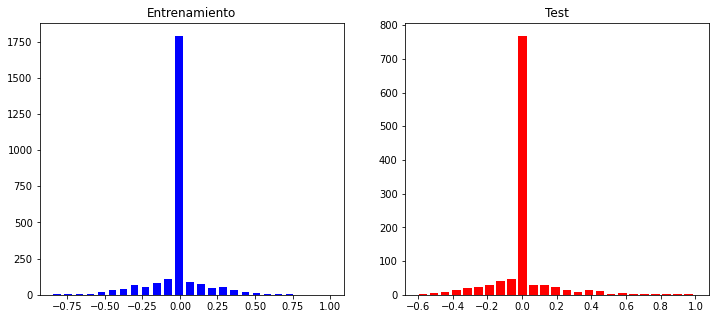

In [ ]:
#Graficamos el valor de steerings para ambas muestras

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_train, bins=num_bins, width=0.05, color='blue')
plt.title("Entrenamiento")
plt.subplot(1,2,2)
plt.hist(y_test, bins=num_bins, width=0.05, color='red')
plt.title("Test")
plt.show()

In [ ]:
#Se define el tamaño final de las imágenes para procesar

img_height, img_width, img_channels = 66, 200, 3

In [ ]:
#Función de preprocesamiento de imágenes

def img_preprocess(img):
  img= mpimg.imread(img)
  img = img[60:140 , : , : ]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  dim = (img_width, img_height)
  img = cv2.resize(img, dim, cv2.INTER_AREA)
  img = img/255
  return img

In [ ]:
#Mostramos un ejemplo de la función de preprocesamiento

#Seleccionamos una imagen
image = image_paths[40]
#Imagen original
original_image = mpimg.imread(image_paths[40])
#Imagen procesada
preprocessed_image = img_preprocess(image)

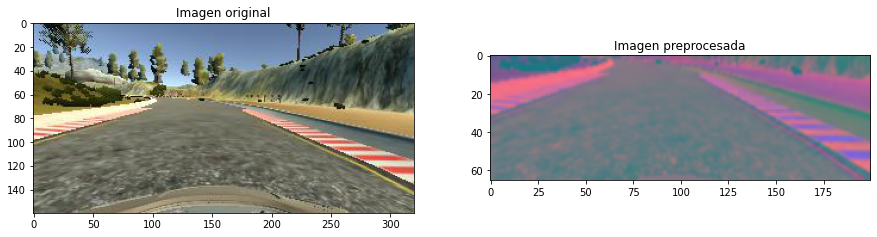

In [ ]:
#Comparamos la imagen original y la procesada

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(preprocessed_image)
plt.title('Imagen preprocesada')
plt.show()

In [ ]:
X_train= np.array(list(map(img_preprocess,X_train)))
X_test =np.array(list(map(img_preprocess,X_test)))

Definición del modelo

In [ ]:
# Definición del modelo de Nvidia

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(img_height, img_width, img_channels), activation='elu'))
  model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
  optimizer = Adam(lr=0.0001)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [ ]:
#Se muestran las etapas del modelo

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

Obtención del modelo

In [ ]:
# Obtención del modelo

history = model.fit(X_train, y_train , epochs=50, validation_data=(X_test, y_test ), batch_size=200,verbose=1)

Epoch 1/50
13/13 [==============================] - 17s 1s/step - loss: 0.0699 - val_loss: 0.0254
Epoch 2/50
13/13 [==============================] - 16s 1s/step - loss: 0.0290 - val_loss: 0.0218
Epoch 3/50
13/13 [==============================] - 16s 1s/step - loss: 0.0255 - val_loss: 0.0218
Epoch 4/50
13/13 [==============================] - 16s 1s/step - loss: 0.0252 - val_loss: 0.0200
Epoch 5/50
13/13 [==============================] - 16s 1s/step - loss: 0.0232 - val_loss: 0.0196
Epoch 6/50
13/13 [==============================] - 16s 1s/step - loss: 0.0226 - val_loss: 0.0192
Epoch 7/50
13/13 [==============================] - 16s 1s/step - loss: 0.0223 - val_loss: 0.0188
Epoch 8/50
13/13 [==============================] - 16s 1s/step - loss: 0.0211 - val_loss: 0.0189
Epoch 9/50
13/13 [==============================] - 16s 1s/step - loss: 0.0224 - val_loss: 0.0179
Epoch 10/50
13/13 [==============================] - 16s 1s/step - loss: 0.0201 - val_loss: 0.0176
Epoch 11/50
13/13 [

Text(0.5, 0, 'Epoch')

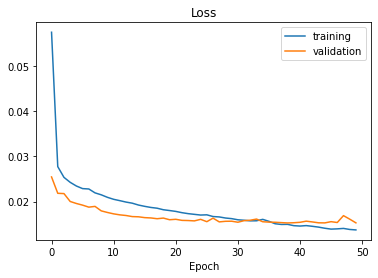

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/SDC_14/modelo_simple_Erick_Casanova.h5')